# Building makemore: building a WaveNet

https://www.youtube.com/watch?v=t3YJ5hKiMQ0

Current architecture: multilayer perceptron with 3 previous characters, predicting next with a single hidden layer (tanh)

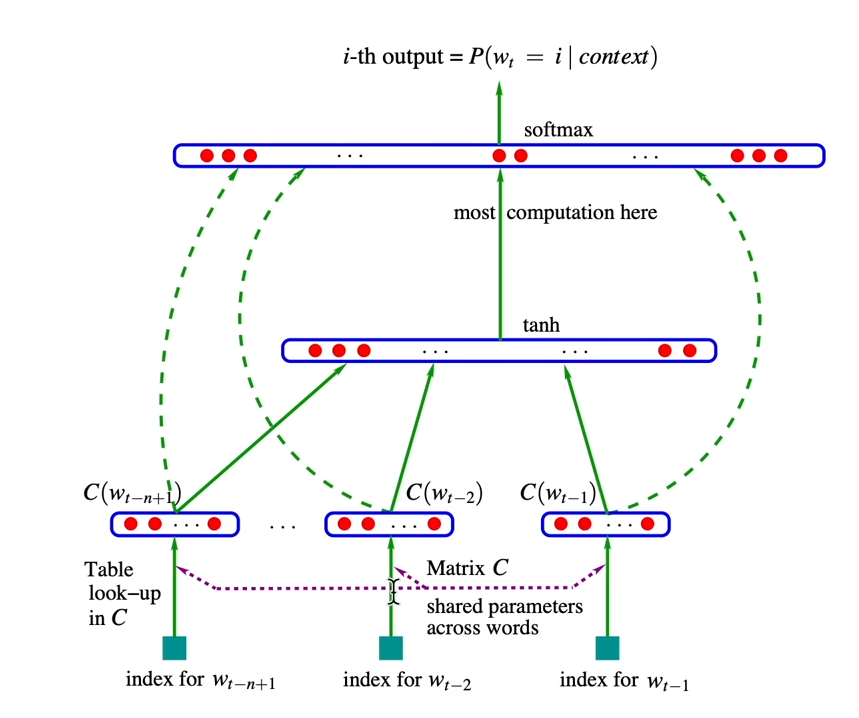

More complex architecture moves toward something that looks like a WaveNet.

2016 publication - was used for predicting audio sequences, but architecture is the same as what we're doing with a recurrent neural network, with a tree-like structure.

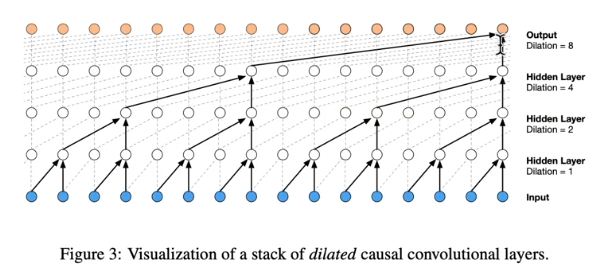

# Starter code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('./makemore/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


Copy of part 3 final code: nice modular blocks that can be stacked into neural network layers. API is similar to the ones in PyTorch.

In [6]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  # Matrix multiplication layer
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  # Normalizes what's passed into the layer
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  # Just Tanh
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [7]:
# This takes the place of the generator g used in previous lectures
torch.manual_seed(42); # seed rng for reproducibility

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


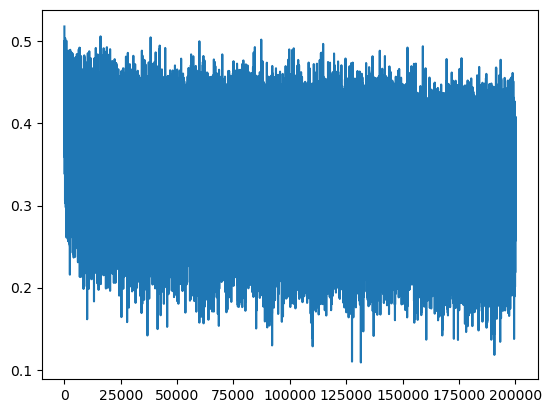

In [11]:
plt.plot(lossi)

This is very "bouncy" because batch size 32 is probably too small. Could use larger batch size to fix this.

In [9]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
  layer.training = False

In [13]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583252906799316
val 2.1065292358398438


This is pretty good. Sampling from the model should yield decent results:

In [14]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
         x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


# Optimizing

## lossi plot

First thing as mentioned above is to get a better lossi plot - the original is much too bouncy.

Recall: in pytorch you can recast a 1D array into a matrix or tensor, etc. Can use this to get a moving average of lossi, rather than the bouncy plot.

In [15]:
print(torch.arange(10))
print(torch.arange(10).view(2, 5))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


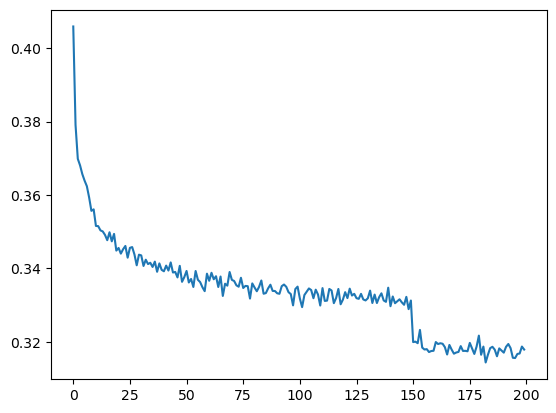

In [16]:
# Stretch into a row of 1000 consecutive elements and do row means
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

This is basically a smoothed average; see around 150k iterations it settled into about the final state.

## Simplifying the forward pass

Current forwad pass takes a lot of lines of code; why not just add embedding definition and the viewing operation to our layers list?

Embedding table lookup is done with indexing, and view option rearranges the character embeddings and stretches them into a row. Can easily be made into simple functions.

New defs (same signature as Pytorch as before):

In [10]:
# -----------------------------------------------------------------------------------------------
class Embedding:
  # Indexing operation for the forward pass
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
# -----------------------------------------------------------------------------------------------
class Flatten:
  # Flattening operation
  
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

In [11]:
torch.manual_seed(42); # Reset seed

In [12]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
# Don't need C anymore

layers = [
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # These are inside layers now
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.2966


First iteration runs: great!

## Sequentials

Concept of containers, a way of organizing layers into lists, dicts, etc. We want to create one that passes a list of containers.

In [14]:
# -----------------------------------------------------------------------------------------------
class Sequential:
  # Pass in a list of layers
  # In forward pass, pass in layers and return result
  # Parameters iterate through the child modules
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [15]:
torch.manual_seed(42); # Reset seed

In [16]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
# Don't need C anymore

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
#parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [17]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # Now just call the model on the input data
  #x = Xb
  #for layer in layers:
  #  x = layer(x)
  logits = model(Xb)
  #loss = F.cross_entropy(x, Yb) # loss function
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.4915


Again, first iterations run fine.

Also need to update the loss evaluation and sampling functions with our new model object.

In [18]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

Very important to run the above or batchnorm layer will cause issues (variance of single number is NaN) which pollutes further processing. He explains this error in the video around 16:00.

In [26]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Replace all this with our model
  #emb = C[x] # (N, block_size, n_embd)
  #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  #for layer in layers:
  #  x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.5309441089630127
val 3.5351996421813965


In [27]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      #emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      #x = emb.view(emb.shape[0], -1) # concatenate the vectors
      #for layer in layers:
      #   x = layer(x)
      #logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

c.
vkffpifpvrmvjtdmwmzygntcrbgjvn.
u.
y.
guyibfktcnyxt.
pflqvkcmovxa.
ydzmdgyrsijbc.
uksaksmqpugsugkxccpfsavszsbgsrvxwlziojalyomhzgjfdbfdtkspqubgzfvszaqjpmsakwtjsygxjcdnzghgcuqohebkybltairgtnyignthiguxgoqgtqtucuqrdsxnuvohhtzzaliniisltpziylxwisqnwllafaswkwil.
g.
dfwieokrrktcwdurwreqotckyguygzzdzwhldbfkkygjfbibeosscccfbxkenhfiomklmmrzlvxwqpcfsokqossajlpffafohucniycxcnwjiectfnmvhkzgcvsllfv.
qjtdqxbcj.
njyowtbaksqx.
hlqvjjpvoopqpqsofwubuocz.
pexinv.
exdwuilfyfj.
vmwdqxhltrjgrolacnlfttedjfuhyydnnuoggx.
efbttzcsbgfs.
dlxteejigdso.
rdwztegoguzsqfbvecnbzkvhztlsdoqvqn.
exlriljjdezv.


# Updated model

Running the new model:

In [19]:
torch.manual_seed(42); # Reset seed

In [20]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
# Don't need C anymore

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
#parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [30]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # Now just call the model on the input data
  #x = Xb
  #for layer in layers:
  #  x = layer(x)
  logits = model(Xb)
  #loss = F.cross_entropy(x, Yb) # loss function
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4915
  10000/ 200000: 2.2179
  20000/ 200000: 2.3681
  30000/ 200000: 2.1342
  40000/ 200000: 2.4067
  50000/ 200000: 2.2406
  60000/ 200000: 1.9608
  70000/ 200000: 1.9236
  80000/ 200000: 2.6588
  90000/ 200000: 2.0502
 100000/ 200000: 2.2596
 110000/ 200000: 1.6270
 120000/ 200000: 2.1705
 130000/ 200000: 2.2806
 140000/ 200000: 2.1980
 150000/ 200000: 1.8434
 160000/ 200000: 1.8251
 170000/ 200000: 2.3077
 180000/ 200000: 2.0817
 190000/ 200000: 2.1585


In [21]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [32]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Replace all this with our model
  #emb = C[x] # (N, block_size, n_embd)
  #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  #for layer in layers:
  #  x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.058220624923706
val 2.1056690216064453


Losses are similar in training and validation set, so we don't have to worry about overfitting. Can continue making model more complex.

In [33]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      #emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      #x = emb.view(emb.shape[0], -1) # concatenate the vectors
      #for layer in layers:
      #   x = layer(x)
      #logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

damiara.
alyza.
poh.
tri.
gerryshamily.
lorie.
rosso.
jemae.
cani.
aini.
zaydentyn.
ashira.
jah.
grancealynna.
jamaurole.
farashton.
sabigianner.
tyre.
dia.
beir.


# WaveNet

Motivation: in current model, all input information is squashed into a single layer and then further processed. WaveNet makes bigrams, fuses the bigrams, fuses again etc. in a tree-like hierarchical manner.

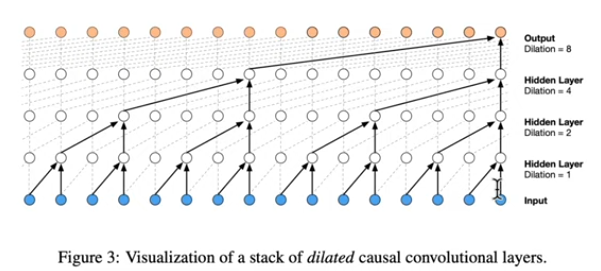

"Dilated causal convultional layers" - fuse 2 neighboring elements sequentially.

The new model will allow us to create a block size 8 (power of 2) dataset to predict 9th character. Lots more information feeding in.

In [41]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [42]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [44]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> l
......el --> i
.....eli --> a
....elia --> n
...elian --> y
..eliany --> s
.elianys --> .
........ --> t
.......t --> r
......tr --> o
.....tro --> y
....troy --> .
........ --> m
.......m --> a
......ma --> r
.....mar --> k
....mark --> u
...marku --> s
..markus --> .


This is the new block size 8: much more available information.

In [45]:
torch.manual_seed(42); # seed rng for reproducibility

In [46]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


Added 10,000 parameters by increasing block size to 8.

In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.0670
  10000/ 200000: 2.3204
  20000/ 200000: 2.3236
  30000/ 200000: 2.2452
  40000/ 200000: 1.7257
  50000/ 200000: 1.7862
  60000/ 200000: 2.0928
  70000/ 200000: 1.9361
  80000/ 200000: 1.8628
  90000/ 200000: 2.3545
 100000/ 200000: 1.8543
 110000/ 200000: 2.2833
 120000/ 200000: 2.0504
 130000/ 200000: 2.0108
 140000/ 200000: 1.6465
 150000/ 200000: 2.4707
 160000/ 200000: 2.1322
 170000/ 200000: 1.8814
 180000/ 200000: 1.7131
 190000/ 200000: 1.9555


In [51]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [52]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Replace all this with our model
  #emb = C[x] # (N, block_size, n_embd)
  #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  #for layer in layers:
  #  x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9214235544204712
val 2.0176022052764893


Still runs. Loss curve looks fine as well.

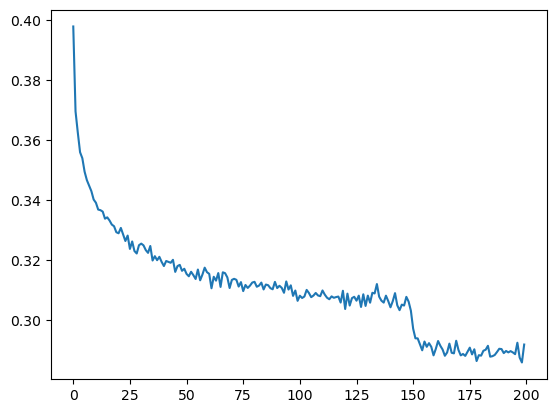

In [50]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

Can look at shape of tensors as the network is finishing.

In [55]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
# 4 examples x 8 character context
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  0,  0,  9,  6, 21],
        [ 0,  0,  0,  0, 11,  5,  1,  7],
        [ 0,  0,  0, 18,  1,  1,  8,  9]])


In [56]:
# plucks out vector for each integer, 4 x 8 x 10
model.layers[0].out.shape # output of Embedding

torch.Size([4, 8, 10])

In [57]:
# Long row / concatenation operation, 4 x 80
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [58]:
# Linear layer has 200 neurons
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

# Implementing WaveNet

Recall linear layer does matrix multiplication and has some sort of bias term.

In [59]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

Matrix multiplication `@` operator can be used on higher dimensional tensors: matrix multiplication occurs on last dimension. We can use this in more advanced network architectures.

In [60]:
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

So our batches, e.g. characters (1 2) (3 4) (5 6) (7 8) can be processed in parallel.

In [61]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

If we tweak the Linear and Flatten layers we can replicate this behavior.

In [68]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([
    e[:, ::2, :] # even elements
    , e[:, 1::2, :] # odd elements
], dim = 2)
explicit.shape

torch.Size([4, 4, 20])

In [69]:
# As before use view() to recast
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [70]:
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  # Flattening operation
  
  # New constructor
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    # New arg
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n) # Consecutive elements to flatten
    # Check if T//n = 1; return a 2-dimensional tensor in that case
    if x.shape[1] == 1:
        x = x.squeeze(1) # removes dimension of 1 from index 1 in the tensor
    self.out = x
    #self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

In [71]:
torch.manual_seed(42); # seed rng for reproducibility

In [73]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  # New code: use FlattenConsecutive
  #Flatten(),
  FlattenConsecutive(8), # replicate old behavior
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [74]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
# 4 examples x 8 character context
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0, 18],
        [ 0,  0,  0,  0,  0,  1, 14, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  0,  2, 18,  5]])


In [75]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


All the dimensions are as expected.

In [78]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  # New code: use FlattenConsecutive
  # FlattenConsecutive(8), # replicate old behavior
  # Repeat 3 times, as 2^3 = 8
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

170897


Much bigger model! Now let's look at the tensors dimensions.

In [80]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
# 4 examples x 8 character context
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  4,  9,  1, 12,  1],
        [ 0,  0,  0, 14, 26, 21, 18,  9],
        [ 0,  0,  0,  1, 20,  9, 25,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  1]])


In [81]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [82]:
logits.shape

torch.Size([4, 27])

All working as expected.

## Testing the WaveNet model

Reduce the total parameters to be ~22000, comparable to before; we want to compare model architectures, not just adding more parameters. If the new model performs better that implies the new architecture utilizes them more effectively.

In [84]:
torch.manual_seed(42); # seed rng for reproducibility

In [85]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  # New code: use FlattenConsecutive
  # FlattenConsecutive(8), # replicate old behavior
  # Repeat 3 times, as 2^3 = 8
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [86]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4682
  10000/ 200000: 2.0722
  20000/ 200000: 2.0874
  30000/ 200000: 2.3199
  40000/ 200000: 1.9045
  50000/ 200000: 1.6174
  60000/ 200000: 2.0639
  70000/ 200000: 1.8035
  80000/ 200000: 2.5321
  90000/ 200000: 1.7779
 100000/ 200000: 1.5623
 110000/ 200000: 2.0421
 120000/ 200000: 1.7374
 130000/ 200000: 1.9858
 140000/ 200000: 1.9646
 150000/ 200000: 1.6728
 160000/ 200000: 1.6362
 170000/ 200000: 1.8153
 180000/ 200000: 1.9158
 190000/ 200000: 2.0730


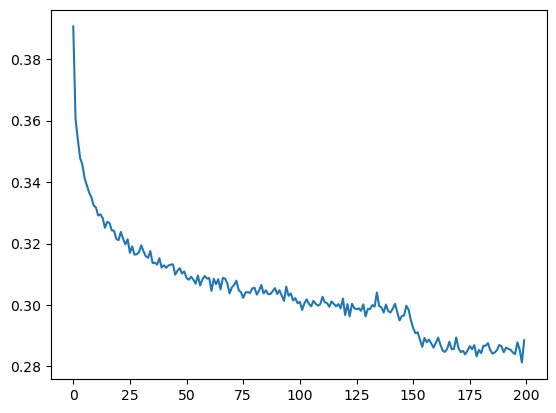

In [87]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [88]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Replace all this with our model
  #emb = C[x] # (N, block_size, n_embd)
  #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  #for layer in layers:
  #  x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9093579053878784
val 2.0188682079315186


This took significantly longer to train for me, and we haven't gained much of anything yet.

## Fixing BatchNorm

Look at the layers.

In [89]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (22902, 8, 10)
FlattenConsecutive : (22902, 4, 20)
Linear : (22902, 4, 68)
BatchNorm1d : (22902, 4, 68)
Tanh : (22902, 4, 68)
FlattenConsecutive : (22902, 2, 136)
Linear : (22902, 2, 68)
BatchNorm1d : (22902, 2, 68)
Tanh : (22902, 2, 68)
FlattenConsecutive : (22902, 136)
Linear : (22902, 68)
BatchNorm1d : (22902, 68)
Tanh : (22902, 68)
Linear : (22902, 27)


Note that BatchNorm1d takes in (22902, 4, 68); when we wrote it, the function assumes x is 2-dimensional. But now we're passing a 3D tensor, so there's a bug. Code still ran due to broadcasting the dimensions correctly but it's not finding the correct mean/sd.

In [91]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim = True) # 1, 4, 68
evar = e.var(0, keepdim = True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

We should be averaging over 32 * 4 numbers, not just 32 numbers in the batch during training. This should also lead to less "bouncy" lossi plots, due to predicting with 4x more observations than when just using the 32 batch size.

In [93]:
e = torch.randn(32, 4, 68)
# Add tuples
emean = e.mean((0, 1), keepdim = True) # 1, 4, 68
evar = e.var((0, 1), keepdim = True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [97]:
emean.shape

torch.Size([1, 1, 68])

1 x 1 x 68 as desired. Now to fix the `BatchNorm1d` layer:

In [ ]:
# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      # New code: Check if we're using a 2D or 3D tensor
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [95]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 1.9740


In [96]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

## Refitted model

Add some more embeddings and hidden layers.

In [98]:
torch.manual_seed(42); # seed rng for reproducibility

In [99]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  # New code: use FlattenConsecutive
  # FlattenConsecutive(8), # replicate old behavior
  # Repeat 3 times, as 2^3 = 8
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [100]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.5774
  10000/ 200000: 2.1247
  20000/ 200000: 2.2139
  30000/ 200000: 2.5075
  40000/ 200000: 2.0262
  50000/ 200000: 1.8346
  60000/ 200000: 1.7380
  70000/ 200000: 1.7636
  80000/ 200000: 2.4363
  90000/ 200000: 2.0325
 100000/ 200000: 1.7564
 110000/ 200000: 1.8755
 120000/ 200000: 1.6652
 130000/ 200000: 2.1813
 140000/ 200000: 1.9208
 150000/ 200000: 1.7225
 160000/ 200000: 1.6349
 170000/ 200000: 2.0850
 180000/ 200000: 1.8459
 190000/ 200000: 1.9942


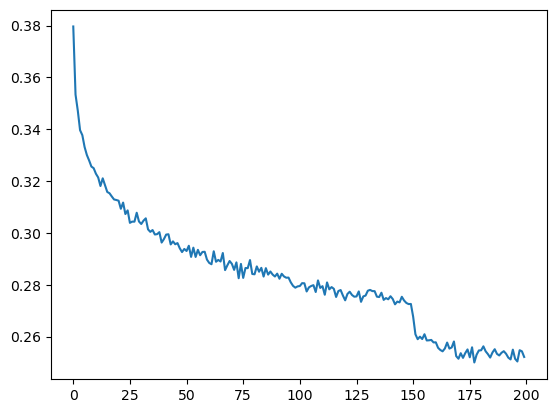

In [102]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [103]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [104]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Replace all this with our model
  #emb = C[x] # (N, block_size, n_embd)
  #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  #for layer in layers:
  #  x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.768534779548645
val 1.9889519214630127


Slowest training yet, but the loss on the validated set crossed 2.0.

Would really like some "experimental harness" to try different `n_embd`, `n_hidden values` but it's out of scope for this lecture. Setting this up is an important part of real development.

Potential optimizations: different n_embd, different parameter initialization, impliment other features from the paper.

## Performance log

* Original (3 character context + 200 hidden neurons, 12k params): train 2.058, val 2.105
* Context: 3 -> 8 (22k params): train 1.92, val 2.02
* flat -> hierarchical (22k params): train 1.91, val 2.02
* scaled up network: n_embd 24, n_hidden 128: (76k params): train 1.77, val 1.99

## Thoughts on convolutional neural networks

The point of convolution was efficiency; didn't really change the model we made conceptually.

In [110]:
for x,y in zip(Xtr[0:8], Ytr[0:8]):
    print(''.join(itos[ix.item()] for ix in x), '->>', itos[y.item()])

........ ->> e
.......e ->> l
......el ->> i
.....eli ->> a
....elia ->> n
...elian ->> y
..eliany ->> s
.elianys ->> .


In [105]:
# forward a single exmaple:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

8 independent calls to the model is slow.

In [111]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

Conceptually, we're passing the whole sequence into PyTorch which then performs operations in kernels in CUDA (much faster).

"Convolution is a "for loop" applying Linear layers efficiently over space" (?) - presumably "space" is the input text. Takes advantage of CUDA optimization but also reuse of nodes due to the WaveNet architecture. Each node is used twice but only passed once.

# Thoughts on network architecture

Various classes we developed are very similar to Torch.nn; the last couple lectures basically created it from scratch. Nice modular code allows stacking layers like we did in our code.

Aside: apprently PyTorch documentation is not maintained, so user beware.

Debugging takes lots of time tinking through the shapes of different layers and making sure broadcasting works correctly. Andrej actually uses Jupyter notebooks to prototype and verify everything's working correctly.